<a href="https://colab.research.google.com/github/voshna123/BITCOIN_price_predictor/blob/main/Bitcoin_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get data

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2025-01-22 09:13:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2025-01-22 09:13:36 (7.88 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-01-22 09:13:37--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-01-22 09:13:37 (20.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



#Import

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
data = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", parse_dates=['Date'], index_col = ['Date'])
data.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [5]:
len(data),data.describe(),

(2787,
        Closing Price (USD)  24h Open (USD)  24h High (USD)  24h Low (USD)
 count          2787.000000     2787.000000     2787.000000    2787.000000
 mean           6529.845141     6513.579485     6710.061683    6302.417386
 std           10887.847444    10863.800772    11206.779756   10475.811252
 min             108.584830      108.584830      118.675000      83.328330
 25%             460.087500      459.400500      469.720995     450.818830
 50%            2780.182500     2772.367500     2874.696250    2696.457500
 75%            8506.923720     8496.887593     8763.291985    8221.060570
 max           63346.789035    63562.673545    64801.787870   62094.632914)

In [6]:
data = data.rename(columns = {'Closing Price (USD)': 'Price'})
df = pd.DataFrame(data['Price'])
df

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


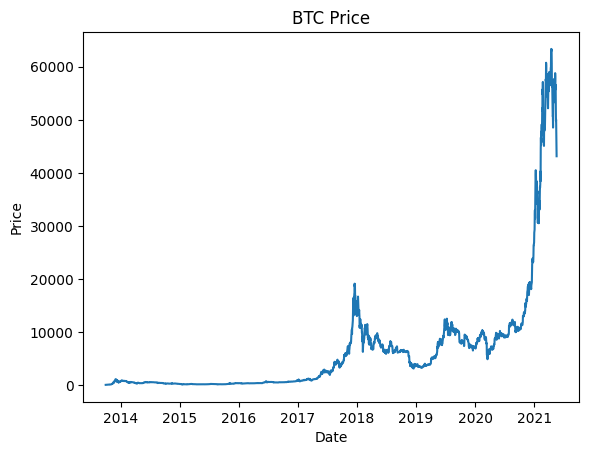

In [7]:
plt.plot(df)
plt.ylabel("Price")
plt.xlabel("Date")
plt.title("BTC Price")
plt.show()

In [8]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implementation of MASE
  """

  mae =tf.reduce_mean(tf.abs(y_true - y_pred))

  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return (mae/mae_naive_no_season).numpy()

## Create evaluate preds

In [9]:
def evaluate_preds(y_true, y_pred):
  """
  Prints MAE, MSE, RMSE and MASE
  """

  #Make sure its in float 32
  y_true = tf.cast(y_true, dtype = tf.float32)
  y_pred = tf.cast(y_pred, dtype = tf.float32)

  mae = tf.keras.metrics.MeanAbsoluteError()
  mae.update_state(y_true, y_pred)

  mse = tf.keras.metrics.MeanSquaredError()
  mse.update_state(y_true, y_pred)

  mape = tf.keras.metrics.MeanAbsolutePercentageError()
  mape.update_state(y_true, y_pred)

  rmse = tf.sqrt(mse.result())

  if mae.result().ndim>0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    mape = tf.reduce_mean(mape)
    rmse = tf.reduce_mean(rmse)

  return pd.DataFrame({"MAE": mae.result().numpy(),
                      "MSE": mse.result().numpy(),
                      "RMSE": rmse.numpy(),
                      "MASE": mean_absolute_scaled_error(y_true, y_pred),
                      "MAPE": mape.result().numpy()}, index = [0])

# Model: N-BEATS algorithm

## Building N-BEATS block layer

In [10]:
class NBEATSBLOCK(tf.keras.layers.Layer):
  def __init__(self,
               input_size:int,
               theta_size:int,
               horizon:int,
               n_neurons:int,
               n_layers:int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden =[tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size,activation='linear', name = 'theta')


  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)

    # output backcast and forecast
    backcast, forecast = theta[:,:self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

### testing NBEATS blocks

In [11]:
WINDOW_SIZE =7
HORIZON =1

In [12]:
dummy_layer = NBEATSBLOCK(WINDOW_SIZE, WINDOW_SIZE+HORIZON, HORIZON, 128, 4)

In [13]:
dummy_input = tf.expand_dims(tf.range(WINDOW_SIZE)+1 , axis =0)
dummy_input

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [14]:
backcast, forecast = dummy_layer(dummy_input)

In [15]:
backcast,forecast

(<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
 array([[-0.06894904,  2.090345  ,  0.33773553,  0.41166914,  1.0968056 ,
          0.7779074 ,  0.9925331 ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.6296932]], dtype=float32)>)

## preparing data for NBEATS algo

In [16]:
HORIZON = 1
WINDOW_SIZE = 7

In [17]:
df_uni = df.copy()
df_uni

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


In [18]:
for i in range(WINDOW_SIZE):
  df_uni[f"Price+{i+1}"] = df_uni["Price"].shift(periods= i+1)
df_uni = df_uni.dropna()
df_uni

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.033000,121.795000,120.655330,121.338660,118.674660,108.584830,125.455000,123.654990
2013-10-09,124.049000,123.033000,121.795000,120.655330,121.338660,118.674660,108.584830,125.455000
2013-10-10,125.961160,124.049000,123.033000,121.795000,120.655330,121.338660,118.674660,108.584830
2013-10-11,125.279660,125.961160,124.049000,123.033000,121.795000,120.655330,121.338660,118.674660
2013-10-12,125.927500,125.279660,125.961160,124.049000,123.033000,121.795000,120.655330,121.338660
...,...,...,...,...,...,...,...,...
2021-05-14,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679


In [19]:
X = df_uni.drop('Price', axis = 1)
Y = df_uni['Price']

split_size = int(len(X)*0.8)

X_train, X_test, Y_train, Y_test = X[:split_size], X[split_size:], Y[:split_size], Y[split_size:]
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((2224, 7), (556, 7), (2224,), (556,))

In [20]:
X_train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
X_test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
Y_train_dataset = tf.data.Dataset.from_tensor_slices(Y_train)
Y_test_dataset = tf.data.Dataset.from_tensor_slices(Y_test)

train_dataset = tf.data.Dataset.zip((X_train_dataset, Y_train_dataset)).batch(1024).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.zip((X_test_dataset, Y_test_dataset)).batch(1024).prefetch(tf.data.AUTOTUNE)

## Setting up hyperparameters

In [21]:
N_EPOCHS = 1000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = HORIZON+INPUT_SIZE

INPUT_SIZE, THETA_SIZE

(7, 8)

#Making residual connections

In [22]:
nbeats_block_layer =NBEATSBLOCK(INPUT_SIZE,
                                THETA_SIZE,
                                HORIZON,
                                N_NEURONS,
                                N_LAYERS)

stack_inputs = tf.keras.layers.Input(shape = (INPUT_SIZE,))

residuals, forecast = nbeats_block_layer(stack_inputs)

for i, _ in enumerate(range(N_STACKS-1)):
  backcast, block_forecast = NBEATSBLOCK(INPUT_SIZE,
                                THETA_SIZE,
                                HORIZON,
                                N_NEURONS,
                                N_LAYERS)(residuals)

  residuals = tf.keras.layers.subtract([residuals,backcast])
  forecast = tf.keras.layers.add([forecast, block_forecast])

model_7 = tf.keras.Model(stack_inputs, outputs = forecast)

In [23]:
model_7.compile(loss = tf.keras.losses.MeanAbsoluteError(),
                optimizer = tf.keras.optimizers.Adam())

In [24]:
model_7.fit(train_dataset,
            epochs = N_EPOCHS,
            validation_data = test_dataset,
            callbacks =[tf.keras.callbacks.EarlyStopping(monitor ='val_loss',
                                                         patience = 50,
                                                         restore_best_weights = True),
                        tf.keras.callbacks.ReduceLROnPlateau(patience = 40)
                        ])

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 67s 7s/step - loss: 727.1918 - val_loss: 13724.8125 - learning_rate: 0.0010
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - loss: 2330.4026 - val_loss: 9429.2285 - learning_rate: 0.0010
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 2107.8806 - val_loss: 17139.0293 - learning_rate: 0.0010
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 1819.3225 - val_loss: 5862.8096 - learning_rate: 0.0010
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 632.5807 - val_loss: 6993.6240 - learning_rate: 0.0010
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1472.7108 - val_loss: 8766.6680 - learning_rate: 0.0010
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1623.9031 - val_loss: 13306.9062 - learning_rate: 0.0010
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1513.8774 - val_loss: 8685.3760 - learning_rate: 0.0010
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 956.8456 - val_lo

In [25]:
model_7.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 582.0522


582.0521850585938

In [26]:
model_7_preds = model_7.predict(test_dataset)
model_7_results = evaluate_preds(Y_test, model_7_preds)
model_7_results

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


,MAE,MSE,RMSE,MASE,MAPE
0,582.052185,1217656.125,1103.474487,30.111673,2.626729


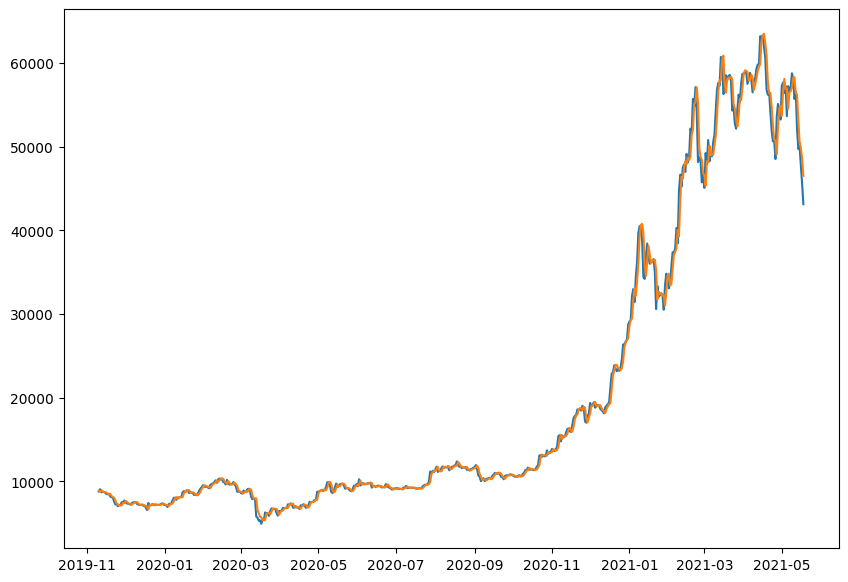

In [28]:
plt.figure(figsize = (10,7))
plt.plot(df.index[2231:], Y_test)
plt.plot(df.index[2231:], model_7_preds)

In [29]:
tf.keras.utils.plot_model(model_7, show_shapes = True)